# Dataset download
In this section the dataset is downloaded from *Kaggle*, unzipped and well formatted.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d ikarus777/best-artworks-of-all-time
! unzip best-artworks-of-all-time.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflati

#Data preprocessing

In [ ]:
artists = pd.read_csv('artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
#artists_top = artists_top.loc[artists_top['paintings'] >200]
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [ ]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

Next step is to solve a problem: the downloaded dataset present two directory containing the same paintings but they have different name. What we do in the next cells is to create a single directory called 'Albrecht_Durer' containing one copy of each painting, and then we delete all unuseful directories.

In [ ]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name
images_dir = 'images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [ ]:
! mv '/content/images/images/Albrecht_Du╠Иrer' /content/images/images/Albrecht_Dürer

In [ ]:
! rm -R '/content/images/images/Albrecht_DuтХа├кrer' 
! rm -R '/content/resized'

#Data fetch

In [ ]:
import pathlib
import os

IMAGE_DIR = '/content/images/'
TRAIN_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'train'))
TEST_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'test'))

IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299
BATCH_SIZE = 128
RANDOM_SEED = 42
VALIDATION_SPLIT = 0.10

In [ ]:
import os
import numpy as np
import shutil

rootdir= '/content/images/images' #path of the original folder
classes = os.listdir(rootdir)

for i, c in enumerate(classes, start=1):
  if c not in artists_top_name.tolist():
    shutil.rmtree(rootdir + '/' + c)
    continue
  if not os.path.exists(rootdir + '/train/' + c):
    os.makedirs(rootdir + '/train/' + c)
  if not os.path.exists(rootdir + '/test/' + c):  
    os.makedirs(rootdir + '/test/' + c)

  source = os.path.join(rootdir, c)
  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.10
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + c)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + c)

In [ ]:
! mv /content/images/images/train /content/images
! mv /content/images/images/test /content/images
! rm -r /content/images/images

In [ ]:
import tensorflow as tf

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='training',
    interpolation='bilinear', follow_links=False
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='validation',
    interpolation='bilinear', follow_links=False
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, interpolation='bilinear', follow_links=False
)


Found 3864 files belonging to 11 classes.
Using 3478 files for training.
Found 3864 files belonging to 11 classes.
Using 386 files for validation.
Found 435 files belonging to 11 classes.


In [ ]:
NUM_CLASSES = len(training_images.class_names)

#Build model

Needed imports:

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import regularizers
import pathlib
import matplotlib.pyplot as plt
import numpy as np

Callback and data augmentation objects:

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='checkpoint_inception.keras',
        monitor='val_loss',
        save_best_only=True,
    )
]
data_augmentation = ks.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1)
    ]
)

##### Inception class:

In [ ]:
class Inception:
    LOSS = 'categorical_crossentropy'

    def __init__(self, train=None, test=None, val=None, classes=11, epochs=10,
                 callbacks_list=None, data_augmentation=None, class_weights=None):
        # set datasets
        self.training_set = train
        self.test_set = test
        self.val_set = val

        # model
        self.model = None

        # utils
        self.history = None
        self.classes = classes
        self.epochs = epochs
        self.callbacks_list = callbacks_list
        self.data_augmentation = data_augmentation
        self.class_weights = class_weights

    """
        ARCHITECTURE TO TEST
    """
    def classic_inception(self):
        inputs = self.input()
        x = self.base_inception()(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def inception_finetuned(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def inception_finetuned_drop(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)
    
    def inception_finetuned_dense(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(512,
                         activation='relu',
                         name='my_dense1')(x)
        x = layers.Dense(256,
                         activation='relu',
                         name='my_dense2')(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)


    """
        NETWORK PIECE BY PIECE STRUCTURE BLOCK
    """

    def input(self):
        inputs = ks.Input(shape=(299, 299, 3))
        x = ks.applications.inception_v3.preprocess_input(inputs)
        x = self.data_augmentation(x)
        x = layers.Rescaling(1. / 255)(x)
        return x

    def base_inception(self):
        res = InceptionV3(
            weights='imagenet',
            include_top=False,
            input_shape=((299, 299, 3))
        )
        res.trainable = False
        return res

    def fine_tuning(self, num_of_blocks=1):
        if num_of_blocks < 1:
            num_of_blocks = 1

        res = self.base_inception()
        res.trainable = True
        set_trainable = False

        if num_of_blocks == 1:
            block_name = 'mixed9'
        elif num_of_blocks == 2:
            block_name = 'mixed8'
        elif num_of_blocks == 3:
            block_name = 'mixed7'
        elif num_of_blocks == 4:
            block_name = 'mixed6'
        else:
            block_name = 'mixed5'

        for layer in res.layers:
            if layer.name == block_name:
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False

        return res

    """
            UTILITIES
    """

    def plot_model(self, model_name):
        ks.utils.plot_model(self.model, model_name, show_shapes=True)

    def plot_accuracy(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        plt.plot(range(1, len(acc) + 1), acc, 'r', label='Training Accuracy')
        plt.plot(range(1, len(acc) + 1), val_acc, 'g', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.plot()

    def plot_loss(self):
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        plt.plot(range(1, len(loss) + 1), loss, 'r', label='Training Loss')
        plt.plot(range(1, len(loss) + 1), val_loss, 'g', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.plot()

    def summary(self):
        self.model.summary()

    """
          COMPILE AND FIT
    """

    def compile_and_fit(self, optimizer):
        self.model.compile(
            optimizer=optimizer,
            loss=self.LOSS,
            metrics=['accuracy']
        )

        if self.callbacks_list is None:
            self.history = self.model.fit(
                self.training_set,
                epochs=self.epochs,
                validation_data=self.val_set
            )
        else:
            self.history = self.model.fit(
                self.training_set,
                epochs=self.epochs,
                validation_data=self.val_set,
                callbacks=self.callbacks_list,
                class_weight=self.class_weights
            )

    def evaluate(self):
        test_loss, test_acc = self.model.evaluate(self.test_set)
        print(f"Test accuracy: {test_acc:.3f}")

#### Feature extraction:

In [ ]:
inception = Inception(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
inception.classic_inception()
inception.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 21,825,323
Trainable params: 22,539
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
inception.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.01))

Epoch 1/60
28/28 [==============================] - 51s 1s/step - loss: 122.0195 - accuracy: 0.1740 - val_loss: 44.6287 - val_accuracy: 0.2591
Epoch 2/60
28/28 [==============================] - 47s 1s/step - loss: 28.8558 - accuracy: 0.3065 - val_loss: 15.5422 - val_accuracy: 0.3705
Epoch 3/60
28/28 [==============================] - 39s 1s/step - loss: 13.4666 - accuracy: 0.3514 - val_loss: 14.4270 - val_accuracy: 0.2902
Epoch 4/60
28/28 [==============================] - 44s 1s/step - loss: 9.9078 - accuracy: 0.3620 - val_loss: 14.7380 - val_accuracy: 0.3523
Epoch 5/60
28/28 [==============================] - 44s 1s/step - loss: 8.6331 - accuracy: 0.3982 - val_loss: 9.3051 - val_accuracy: 0.3782
Epoch 6/60
28/28 [==============================] - 44s 1s/step - loss: 12.6201 - accuracy: 0.3700 - val_loss: 26.1761 - val_accuracy: 0.3187
Epoch 7/60
28/28 [==============================] - 44s 1s/step - loss: 22.7094 - accuracy: 0.3525 - val_loss: 28.0211 - val_accuracy: 0.2772
Epoch 8/

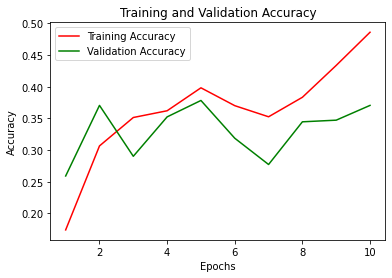

In [ ]:
inception.plot_accuracy()

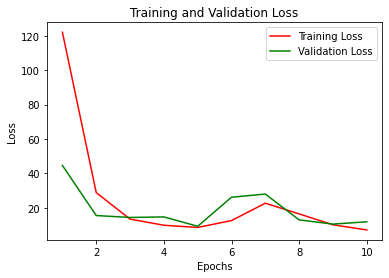

In [ ]:
inception.plot_loss()

In [ ]:
inception.evaluate()

4/4 [==============================] - 6s 810ms/step - loss: 10.9338 - accuracy: 0.4092
Test accuracy: 0.409


## Fine tuning one block

In [ ]:
inception = Inception(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
inception.resnet101_finetuned(num_of_blocks=1)
inception.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 21,825,323
Trainable params: 6,096,075
Non-trainable params: 15,729,248
_________________________________________________________________


In [ ]:
inception.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - 54s 1s/step - loss: 2.0521 - accuracy: 0.3991 - val_loss: 13.7652 - val_accuracy: 0.0881
Epoch 2/60
28/28 [==============================] - 45s 1s/step - loss: 1.4857 - accuracy: 0.5451 - val_loss: 3.4008 - val_accuracy: 0.2150
Epoch 3/60
28/28 [==============================] - 45s 1s/step - loss: 1.1440 - accuracy: 0.6458 - val_loss: 2.5772 - val_accuracy: 0.3005
Epoch 4/60
28/28 [==============================] - 46s 1s/step - loss: 0.7949 - accuracy: 0.7562 - val_loss: 2.3941 - val_accuracy: 0.3342
Epoch 5/60
28/28 [==============================] - 45s 1s/step - loss: 0.5658 - accuracy: 0.8183 - val_loss: 1.8444 - val_accuracy: 0.4663
Epoch 6/60
28/28 [==============================] - 46s 1s/step - loss: 0.4022 - accuracy: 0.8723 - val_loss: 2.3868 - val_accuracy: 0.4067
Epoch 7/60
28/28 [==============================] - 46s 1s/step - loss: 0.2745 - accuracy: 0.9123 - val_loss: 2.3149 - val_accuracy: 0.3886
Epoch 8/60
28/28 [=

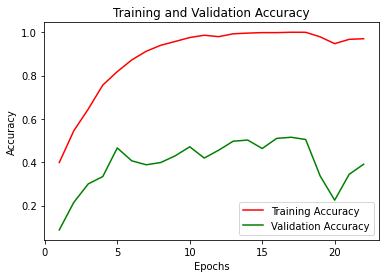

In [ ]:
inception.plot_accuracy()

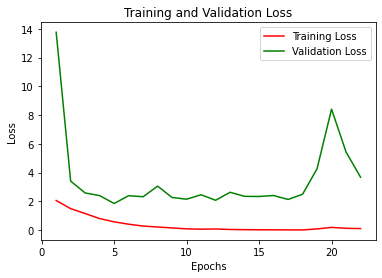

In [ ]:
inception.plot_loss()

In [ ]:
inception.evaluate()

4/4 [==============================] - 6s 806ms/step - loss: 3.3541 - accuracy: 0.4437
Test accuracy: 0.444


### Finetuned 2 blocks

In [ ]:
inception = Inception(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
inception.resnet101_finetuned(num_of_blocks=2)
inception.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 21,825,323
Trainable params: 11,137,419
Non-trainable params: 10,687,904
_________________________________________________________________


In [ ]:
inception.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - 58s 2s/step - loss: 1.9739 - accuracy: 0.4025 - val_loss: 21.4677 - val_accuracy: 0.0725
Epoch 2/60
28/28 [==============================] - 48s 1s/step - loss: 1.5147 - accuracy: 0.5365 - val_loss: 12.9946 - val_accuracy: 0.0933
Epoch 3/60
28/28 [==============================] - 48s 1s/step - loss: 1.1482 - accuracy: 0.6455 - val_loss: 6.1268 - val_accuracy: 0.1891
Epoch 4/60
28/28 [==============================] - 48s 1s/step - loss: 0.9348 - accuracy: 0.7133 - val_loss: 4.0951 - val_accuracy: 0.2798
Epoch 5/60
28/28 [==============================] - 46s 1s/step - loss: 0.7379 - accuracy: 0.7507 - val_loss: 2.5773 - val_accuracy: 0.3575
Epoch 6/60
28/28 [==============================] - 46s 1s/step - loss: 0.5545 - accuracy: 0.8186 - val_loss: 4.2817 - val_accuracy: 0.3316
Epoch 7/60
28/28 [==============================] - 46s 1s/step - loss: 0.3980 - accuracy: 0.8689 - val_loss: 3.8463 - val_accuracy: 0.3420
Epoch 8/60
28/28 [

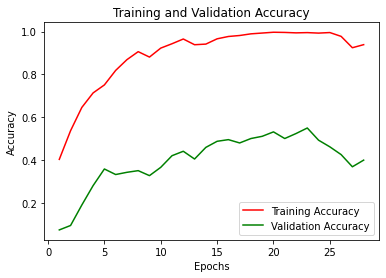

In [ ]:
inception.plot_accuracy()

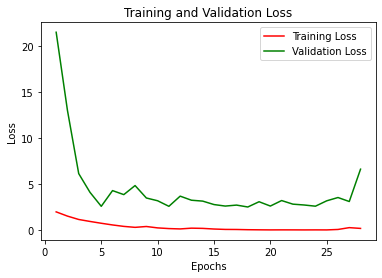

In [ ]:
inception.plot_loss()

In [ ]:
inception.evaluate()

4/4 [==============================] - 11s 848ms/step - loss: 6.3845 - accuracy: 0.4184
Test accuracy: 0.418


### Finetuning 3 

In [ ]:
inception = Inception(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
inception.inception_finetuned(num_of_blocks=3)
inception.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 21,825,323
Trainable params: 12,834,443
Non-trainable params: 8,990,880
_________________________________________________________________


In [ ]:
inception.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.0001))

Epoch 1/60
28/28 [==============================] - 62s 2s/step - loss: 2.1328 - accuracy: 0.3634 - val_loss: 6.9290 - val_accuracy: 0.1166
Epoch 2/60
28/28 [==============================] - 54s 2s/step - loss: 1.4239 - accuracy: 0.5756 - val_loss: 3.8890 - val_accuracy: 0.1503
Epoch 3/60
28/28 [==============================] - 53s 2s/step - loss: 0.9838 - accuracy: 0.7185 - val_loss: 2.7564 - val_accuracy: 0.2487
Epoch 4/60
28/28 [==============================] - 53s 2s/step - loss: 0.6163 - accuracy: 0.8355 - val_loss: 2.1177 - val_accuracy: 0.3808
Epoch 5/60
28/28 [==============================] - 53s 2s/step - loss: 0.3672 - accuracy: 0.9074 - val_loss: 1.7172 - val_accuracy: 0.4508
Epoch 6/60
28/28 [==============================] - 53s 2s/step - loss: 0.2269 - accuracy: 0.9503 - val_loss: 1.5005 - val_accuracy: 0.5337
Epoch 7/60
28/28 [==============================] - 53s 2s/step - loss: 0.1208 - accuracy: 0.9779 - val_loss: 1.4270 - val_accuracy: 0.5699
Epoch 8/60
28/28 [==

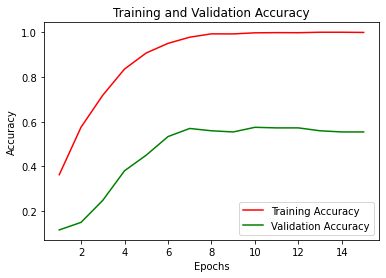

In [ ]:
inception.plot_accuracy()

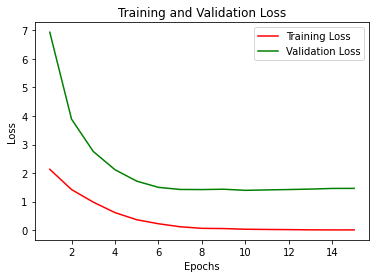

In [ ]:
inception.plot_loss()

In [ ]:
inception.evaluate()

4/4 [==============================] - 9s 948ms/step - loss: 1.4673 - accuracy: 0.5908
Test accuracy: 0.591


#### Ft3 dropout

In [ ]:
inception = Inception(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
inception.inception_finetuned_drop(num_of_blocks=3)
inception.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 21,825,323
Trainable params: 12,834,443
Non-trainable params: 8,990,880
_______________________________________

In [ ]:
inception.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.0001))

Epoch 1/60
28/28 [==============================] - 98s 3s/step - loss: 2.3073 - accuracy: 0.3229 - val_loss: 5.8121 - val_accuracy: 0.0959
Epoch 2/60
28/28 [==============================] - 54s 2s/step - loss: 1.6614 - accuracy: 0.4931 - val_loss: 4.1100 - val_accuracy: 0.1140
Epoch 3/60
28/28 [==============================] - 54s 2s/step - loss: 1.2871 - accuracy: 0.6190 - val_loss: 2.8414 - val_accuracy: 0.2591
Epoch 4/60
28/28 [==============================] - 54s 2s/step - loss: 0.9290 - accuracy: 0.7248 - val_loss: 2.2585 - val_accuracy: 0.3420
Epoch 5/60
28/28 [==============================] - 54s 2s/step - loss: 0.6380 - accuracy: 0.8160 - val_loss: 1.8490 - val_accuracy: 0.4119
Epoch 6/60
28/28 [==============================] - 54s 2s/step - loss: 0.4147 - accuracy: 0.8939 - val_loss: 1.7196 - val_accuracy: 0.4611
Epoch 7/60
28/28 [==============================] - 54s 2s/step - loss: 0.2687 - accuracy: 0.9290 - val_loss: 1.5699 - val_accuracy: 0.4819
Epoch 8/60
28/28 [==

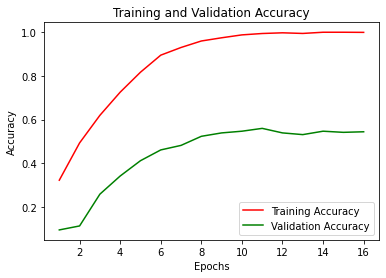

In [ ]:
inception.plot_accuracy()

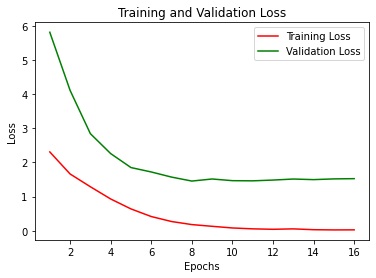

In [ ]:
inception.plot_loss()

In [ ]:
inception.evaluate()

4/4 [==============================] - 8s 907ms/step - loss: 1.3284 - accuracy: 0.6069
Test accuracy: 0.607


#### Finetuned and Exponential Decay

In [ ]:
inception = Inception(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
inception.inception_finetuned(num_of_blocks=3)
inception.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 21,825,323
Trainable params: 12,834,443
Non-trainable params: 8,990,880
_________________________________________________________________


Learning rate is now a ExponentialDecay

In [ ]:
inception.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=ks.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
    decay_steps=25,
    decay_rate=0.9)))

Epoch 1/60
28/28 [==============================] - 74s 2s/step - loss: 1.1310 - accuracy: 0.6725 - val_loss: 9.6034 - val_accuracy: 0.2176
Epoch 2/60
28/28 [==============================] - 53s 2s/step - loss: 0.8095 - accuracy: 0.7358 - val_loss: 8.0823 - val_accuracy: 0.2694
Epoch 3/60
28/28 [==============================] - 53s 2s/step - loss: 0.5840 - accuracy: 0.8025 - val_loss: 3.8550 - val_accuracy: 0.3627
Epoch 4/60
28/28 [==============================] - 53s 2s/step - loss: 0.4258 - accuracy: 0.8554 - val_loss: 3.5334 - val_accuracy: 0.3782
Epoch 5/60
28/28 [==============================] - 59s 2s/step - loss: 0.4619 - accuracy: 0.8456 - val_loss: 3.0002 - val_accuracy: 0.4378
Epoch 6/60
28/28 [==============================] - 53s 2s/step - loss: 0.2926 - accuracy: 0.8985 - val_loss: 2.8175 - val_accuracy: 0.4093
Epoch 7/60
28/28 [==============================] - 52s 2s/step - loss: 0.2010 - accuracy: 0.9290 - val_loss: 2.3753 - val_accuracy: 0.4456
Epoch 8/60
28/28 [==

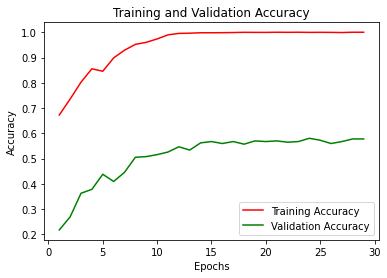

In [ ]:
inception.plot_accuracy()

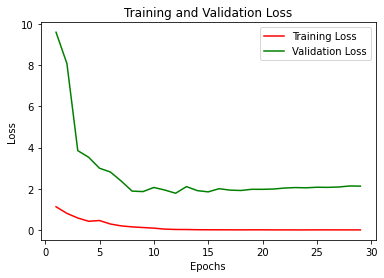

In [ ]:
inception.plot_loss()

In [ ]:
inception.evaluate()

4/4 [==============================] - 6s 869ms/step - loss: 2.3217 - accuracy: 0.6253
Test accuracy: 0.625
